In [1]:
import open3d as o3d
import numpy as np
import multiprocessing as mp
from multiprocessing import Pool
import copy as cp
import open3d.core as o3c
import matplotlib.pyplot as plt
import pyransac3d as pyrsc
import time
from scipy.spatial.transform import Rotation
from iteration_utilities import deepflatten
from mpl_toolkits.mplot3d import Axes3D

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [62]:
#load pcd file, filter, downsample
pcdn = o3d.io.read_point_cloud("final_cropped_ground_align.pcd")
pcdn.estimate_normals()
cl, ind = pcdn.remove_statistical_outlier(nb_neighbors=20,
                                                    std_ratio=0.8)

pcd = pcdn.select_by_index(ind)
pcd = pcd.voxel_down_sample(voxel_size=0.1)
pcd.estimate_normals()
pcd.orient_normals_consistent_tangent_plane(40)
o3d.visualization.draw_geometries([pcd])

In [26]:
# detect boundarys in pointcloud

test2 = cp.deepcopy(pcd)

tensor_pcd = o3d.t.geometry.PointCloud.from_legacy(test2)

boundarys, mask = tensor_pcd.compute_boundary_points(0.2, 100, 95)
# TODO: not good to get size of points.
print(f"Detect {boundarys.point.positions.shape[0]} bnoundary points from {tensor_pcd.point.positions.shape[0]} points.")

boundarys = boundarys.paint_uniform_color([1.0, 0.0, 0.0])
cl, ind = boundarys.to_legacy().remove_radius_outlier(2, 0.2)
boundarys = boundarys.select_by_index(ind)


#o3d.visualization.draw_geometries([tensor_pcd.to_legacy().paint_uniform_color([0, 0, 0.0]), boundarys.to_legacy()])

Detect 15126 bnoundary points from 105811 points.


In [58]:
# detect patches in boundary points

test4 = cp.deepcopy(boundarys.to_legacy())


test4.estimate_normals()
test4.orient_normals_consistent_tangent_plane(30)


n_points = len(test4.points)
#o3d.visualization.draw([pcd_down])
# using all defaults
oboxes = test4.detect_planar_patches(
normal_variance_threshold_deg=60,
coplanarity_deg=80,
outlier_ratio=0.75,
min_plane_edge_length=1,
min_num_points=5,
search_param=o3d.geometry.KDTreeSearchParamKNN(knn=50))

print("Detected {} patches".format(len(oboxes)))

geometries = []
for obox in oboxes:

    mesh = o3d.geometry.TriangleMesh.create_from_oriented_bounding_box(obox, scale=[1, 1, 0.0001])
    mesh.paint_uniform_color(obox.color)
    mesh.compute_triangle_normals()
    mesh.compute_vertex_normals()
    normals = np.asarray(mesh.vertex_normals)

    
    geometries.append(mesh)
    #geometries.append(obox)

#o3d.visualization.draw_geometries(geometries )
#o3d.visualization.draw_geometries([pcd])

Detected 57 patches


In [6]:
def add_vector_to_point(point, vector, length):
    

    # Calculate the new point coordinates
    new_point = point + length * vector

    # Return the new point as a NumPy array
    return new_point

In [7]:
def calc_mesh_area_sorted(meshes):
    areas = np.zeros((len(meshes),2))
    for i in range(len(meshes)):
        mesh_bb = meshes[i].get_oriented_bounding_box()
        area = mesh_bb.volume()/mesh_bb.extent[2]
        areas[i][0] = i
        areas[i][1] = area
    sorted_indices = np.argsort(areas[:, 1])[::-1]
    return areas[sorted_indices]
        

In [8]:
dimensions = calc_mesh_area_sorted(geometries)


In [9]:
def is_perpendicular(angle, threshold):
    
    if (180 <= angle < 360):
        angle -= 180
        
    if ((90-threshold) <= angle <= (90+threshold)):
        return True
    else:
        return False


In [11]:
def compute_transform(vector1, vector2):
    # Normalize the vectors to unit length
    vector1 = vector1 / np.linalg.norm(vector1)
    vector2 = vector2 / np.linalg.norm(vector2)

    # Compute the rotation matrix
    rotation_matrix = Rotation.align_vectors([vector1], [vector2])[0].as_matrix()

    # Compute the translation vector
    translation_vector = vector2 - np.dot(rotation_matrix, vector1)

    return translation_vector, rotation_matrix

In [12]:
def rotation_matrix_to_axis_angle(matrix):
    r = Rotation.from_matrix(matrix)
    return r.as_euler('xyz', degrees=True)

In [13]:
def invert_normalized_vector(vector):
    inverted_vector = []
    for component in vector:
        inverted_component = -component
        inverted_vector.append(inverted_component)
    return inverted_vector

In [14]:
def visualize_3d_vectors(vector1, vector2):
    # Create a figure and a 3D axis
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    
    # normalize vectors
    vector1 = vector1 / np.linalg.norm(vector1)
    vector2 = vector2 / np.linalg.norm(vector2)
    
    if check_vector_similar_direction(vector1, vector2):
        pass
    else:
        pass
        #vector2 = invert_normalized_vector(vector2)
        
    
    # Extract individual coordinates from the vectors
    x1, y1, z1 = vector1
    x2, y2, z2 = vector2
    
    # Plot the vectors as lines
    ax.plot([0, x1], [0, y1], [0, z1], color='r', label='Cam orientation')
    ax.plot([0, x2], [0, y2], [0, z2], color='b', label='Plane normal orientation')
    
    # Set the limits and labels of the plot
    max_x = max(np.max(x1), np.max(x2))
    max_y = max(np.max(y1), np.max(y2))
    max_z = max(np.max(z1), np.max(z2))
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])
    ax.set_zlim([0, 1])
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    
    # Add a legend
    ax.legend()
    
    # Show the plot
    plt.show()

In [15]:
def check_vector_similar_direction(vec1, vec2):
    
    # Normalize the vectors
    normalized_vec1 = np.array(vec1) / np.linalg.norm(vec1)
    normalized_vec2 = np.array(vec2) / np.linalg.norm(vec2)
    
    # Calculate the dot product
    dot_product = np.dot(normalized_vec1, normalized_vec2)
    
    if (dot_product > 0):
        return True
    else:
        return False

In [16]:
def angle_between_vectors(v1, v2):
    """ Returns the angle in radians between vectors 'v1' and 'v2'::

            >>> angle_between((1, 0, 0), (0, 1, 0))
            1.5707963267948966
            >>> angle_between((1, 0, 0), (1, 0, 0))
            0.0
            >>> angle_between((1, 0, 0), (-1, 0, 0))
            3.141592653589793
    """
    # Normalize the vectors to unit length
    v1_u = v1 / np.linalg.norm(v1)
    v2_u = v2 / np.linalg.norm(v2)
    angle = np.arccos(np.clip(np.dot(v1_u, v2_u), -1.0, 1.0))
    
    return np.degrees(angle)


In [17]:
def create_arrow_from_vector(vector, location):
    mesh_normal = vector
    mesh_center = location
    
    #print("Norm average:")
    #print(norm_average)
    
    arrow = o3d.geometry.TriangleMesh.create_cone(0.5,1)
    
    arrow.paint_uniform_color([1,0,0])
    arrow_bb = arrow.get_oriented_bounding_box()
    arrow.compute_triangle_normals()
    arrow.compute_vertex_normals()
    arrow_normal = np.asarray(arrow.vertex_normals)[0]

    translation, rotation = compute_transform(mesh_normal, arrow_normal)  
    
    arrow.rotate(rotation)
    
    arrow.translate(mesh_center, False)
    
    
    arrow_normal = np.asarray(arrow.vertex_normals)[0]
    arrow_center = arrow.get_center()
    same_dir = check_vector_similar_direction(arrow_normal,mesh_normal)
    R_x = np.asarray([[1, 0, 0],
                       [0, -1, 0],
                       [0, 0, -1]])
    
    arrow_cp = o3d.geometry.TriangleMesh.create_cone(0.5,1)
    arrow_cp.paint_uniform_color([1,0,0])
    arrow_cp.compute_triangle_normals()
    arrow_cp.compute_vertex_normals()
    if  (same_dir):
        arrow_cp.rotate(R_x, arrow_center)
        arrow_cp.rotate(rotation)
        arrow_cp.translate(mesh_center, False)
        #return arrow_cp
        return arrow
    else:
        return arrow
    

In [18]:





def count_hits_ray_cast2(process_data):
    
    
    scene_answer =  process_data[0]
    cam_normal = process_data[1]
    dist_thresh = process_data[2]
    angle_thresh = process_data[3]
    
    
    cast_normals = scene_answer['primitive_normals'].numpy()
    cast_distances = scene_answer['t_hit'].numpy()
    
    dist_lower = dist_thresh[0]
    dist_upper = dist_thresh[1]
    n_valid_hits = 0
    flattened_dist_array = cast_distances.flatten()
    n_pixels = len(flattened_dist_array)
    flattened_normal_array = cast_normals.reshape(n_pixels,3)

    

    
    for i in range(n_pixels):
        
        if (flattened_dist_array[i] >= dist_lower) & (flattened_dist_array[i] <= dist_upper):
            pass
        else:
            continue
        
        point_normal = flattened_normal_array[i]
        angle = angle_between_vectors(point_normal, cam_normal)
        
        if is_perpendicular(angle, angle_thresh):
            continue
        else:
            n_valid_hits += 1
        
            
    #n_valid_hits = np.sum((flattened_dist_array >= dist_lower) & (flattened_dist_array <= dist_upper) & angles)
    
    return n_valid_hits/n_pixels

In [28]:
def rank_all_views2(hole_patches, dist_thresh, angle_thresh):
    
    scene = o3d.t.geometry.RaycastingScene()
    hole_centers = []
    hole_normals = []
    cam_positions = []
    cam_normals = []
    hit_areas = []
    scene_answers = []
    dist_threshes = [dist_thresh]*len(hole_patches)
    angle_threshes = [angle_thresh]*len(hole_patches)
    
    tik = time.time() 
    for hole in hole_patches:
        scene.add_triangles(o3d.t.geometry.TriangleMesh.from_legacy(hole))
        center = hole.get_center()
        normal = np.asarray(hole.vertex_normals)[0]
        cam_pos = add_vector_to_point(center, normal, 5)
        cam_pos[2] = 0.5
        center[2] = 0.5
        hole_centers.append(center)
        hole_normals.append(normal)
        cam_positions.append(cam_pos)
        cam_normal = (center-cam_pos)
        cam_normals.append(cam_normal)
    tok = time.time()
    print("time for scene creation:", (tok-tik))
    
    tik = time.time()
    for i in range(len(hole_patches)):
        rays = o3d.t.geometry.RaycastingScene.create_rays_pinhole(
                fov_deg=90,
                center=hole_centers[i],
                eye=cam_positions[i],
                up=[0, 0, -1],
                width_px=500,
                height_px=500)
        ans = scene.cast_rays(rays)
        scene_answers.append(ans)
    tok = time.time()
    print("time for ray casting:", (tok-tik))
    
    
    tik = time.time()
    process_data = zip(scene_answers, cam_normals, dist_threshes, angle_threshes)
    
    with Pool(mp.cpu_count()) as p:
        hit_areas = p.map(count_hits_ray_cast2, process_data)
    tok = time.time()
    print("time for mp hit area calculation:", (tok-tik))
    
    
    return list(zip(hit_areas, cam_positions, cam_normals, scene_answers))



In [29]:
tik2 = time.time()      
ranked_views2 = rank_all_views2(geometries, (2,10), 10 )
tok2 = time.time()

#print(ranked_views2)
#print("overall time:", (tok2-tik2))

time for scene creation: 0.006138324737548828
time for ray casting: 0.1419391632080078
time for mp hit area calculation: 6.262523651123047


In [56]:
#sort views in ascending order according to area covered
ranked_views2.sort(key=lambda x:x[0])

print([view[0] for view in ranked_views2])
best_pos = ranked_views2[-1][1]
best_orientation = ranked_views2[-1][2]

print(best_pos, best_orientation)


[0.0, 0.0, 0.000452, 0.009108, 0.01808, 0.020928, 0.02872, 0.041432, 0.048612, 0.055076, 0.0668, 0.075012, 0.0753, 0.085876, 0.090252, 0.103736, 0.113244, 0.114124, 0.117152, 0.130468, 0.14216, 0.154072, 0.162748, 0.190488, 0.198824, 0.218076, 0.218416, 0.235544, 0.241216, 0.279208, 0.386384, 0.494104, 0.537812, 0.580508]
[-3.90708329  4.85315368  0.5       ] [1.18470829 0.06172201 0.        ]


In [ ]:
vec1 = np.asarray([-1,0,0])
vec2 = np.asarray([0,1,2])

_, rot_mat = compute_transform(vec1 ,vec2)
print(rotation_matrix_to_axis_angle(rot_mat))
print(angle_between_vectors(vec1, vec2))
visualize_3d_vectors(vec1 ,vec2)


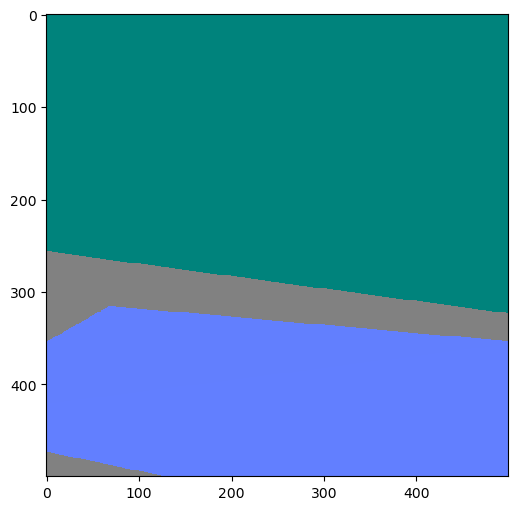

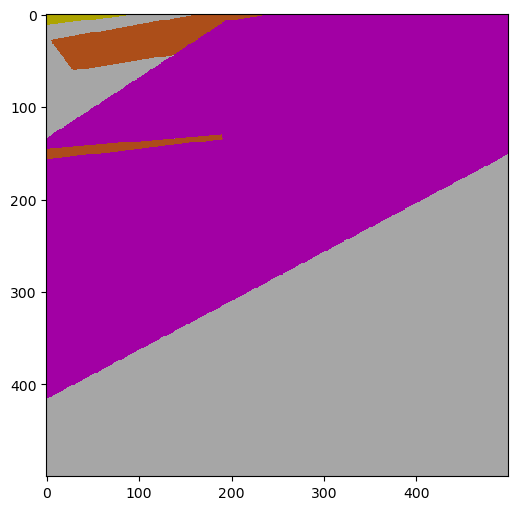

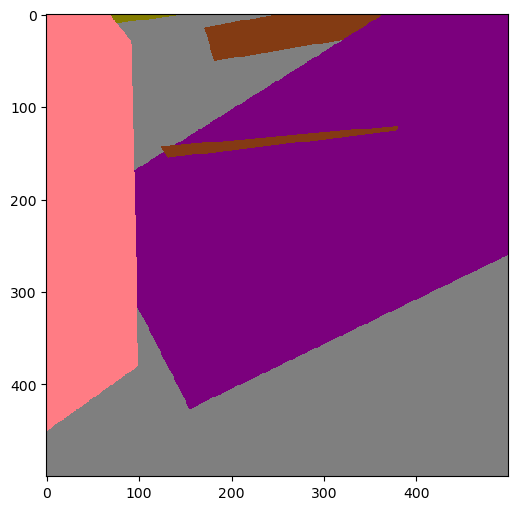

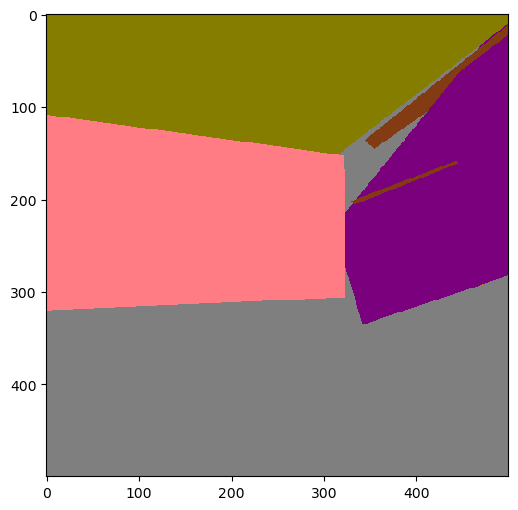

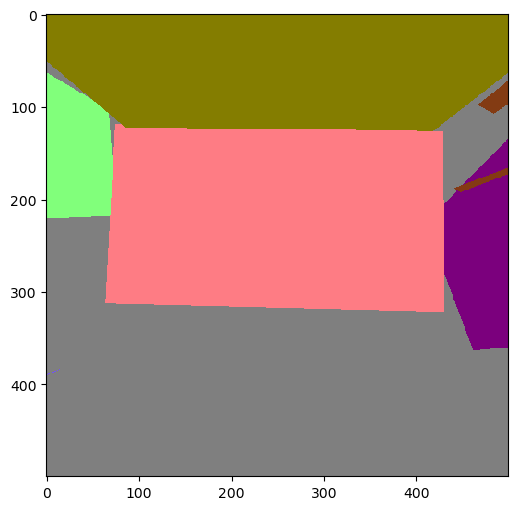

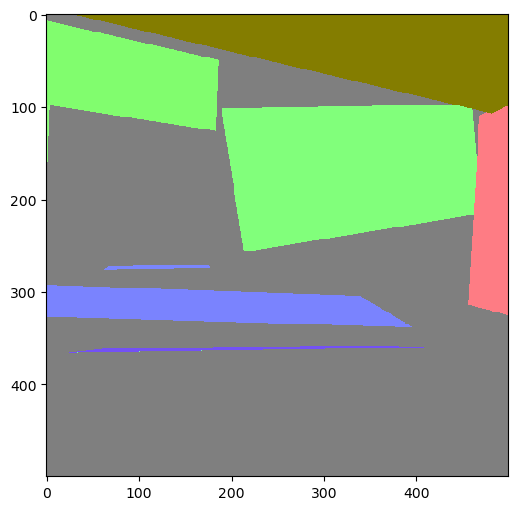

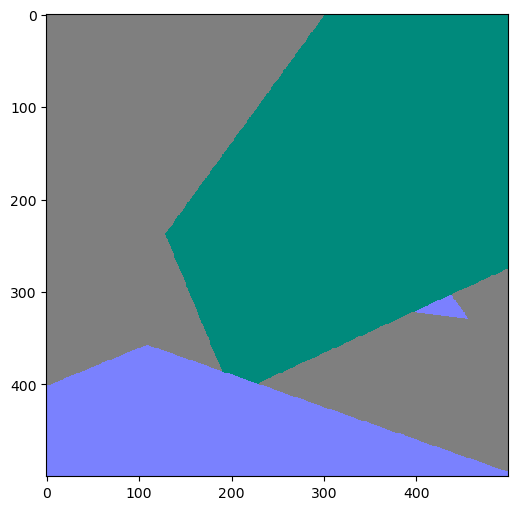

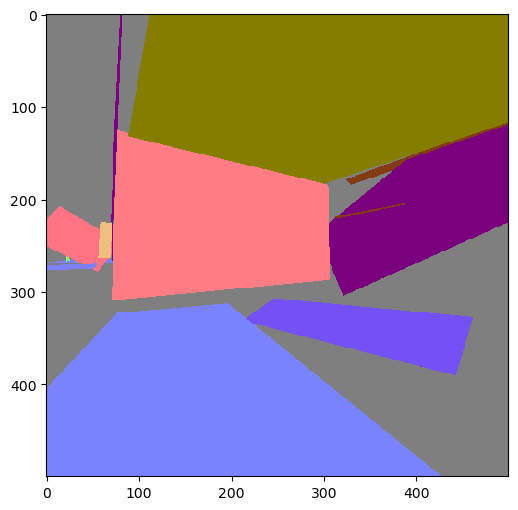

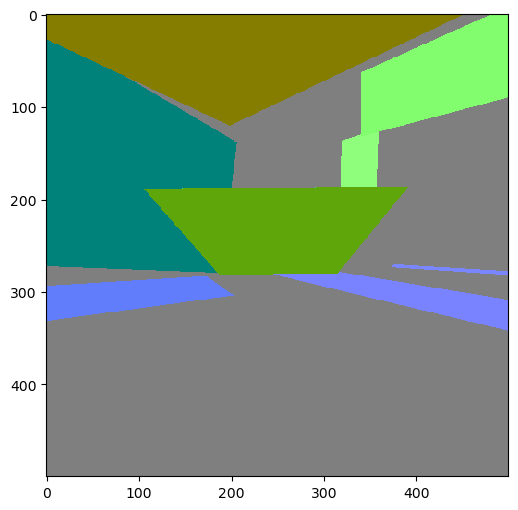

In [64]:
for i in range(1,10):
    best_pos = ranked_views2[-i][1]
    best_orientation = ranked_views2[-i][2]
    best_ans = ranked_views2[-i][3]

    normals = best_ans['primitive_normals'].numpy()
    #normals = np.abs(best_ans['primitive_normals'].numpy())
    hits = best_ans['t_hit'].numpy()
    normals_interp = np.interp(normals, (normals.min(), normals.max()), (0, 1))
    plt.figure(figsize=(10,6))
    plt.imshow(normals_interp) 

In [63]:
ranked_views2[-1][0]

for i in range(1,10):
    best_pos = ranked_views2[-i][1]
    best_orientation = ranked_views2[-i][2]
    best_ans = ranked_views2[-i][3]

    

    cone = create_arrow_from_vector(best_orientation, best_pos)

    o3d.visualization.draw_geometries([pcd] + [cone] )

/tmp/ipykernel_5740/927153186.py:7: UserWarning: Optimal rotation is not uniquely or poorly defined for the given sets of vectors.
  rotation_matrix = Rotation.align_vectors([vector1], [vector2])[0].as_matrix()
